In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import vitaldb
import warnings
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings('ignore')

# --- Cấu hình hệ thống ---
WINDOW_SIZE = 300   # Độ dài chuỗi tín hiệu (300 điểm ảnh hưởng)
N_FEATURES = 3      # Số lượng kênh tín hiệu (MBP, HR, SPO2)
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 30         # Số lượt huấn luyện mỗi fold
K_FOLDS = 5         # Số lớp kiểm chéo
TRACKS = ['ART_MBP', 'PLETH_HR', 'PLETH_SPO2']

In [2]:
# Tải dữ liệu bệnh nhân và phòng thí nghiệm
df_cases = pd.read_csv('https://api.vitaldb.net/cases')
df_labs = pd.read_csv('https://api.vitaldb.net/labs')

# Lọc chỉ số Creatinine (cr)
df_labs = df_labs[df_labs['name'] == 'cr']
df_labs = pd.merge(df_cases[['caseid', 'opend']], df_labs, on='caseid', how='left')

# Tính toán AKI: Nếu Creatinine sau phẫu thuật (7 ngày) > 1.5 lần trước phẫu thuật
df_labs = df_labs[(df_labs['dt'] > df_labs['opend']) & (df_labs['dt'] < df_labs['opend'] + 7 * 24 * 3600)]
max_cr = df_labs.groupby('caseid')['result'].max().reset_index().rename(columns={'result': 'postop_cr'})

df_final = pd.merge(df_cases, max_cr, on='caseid', how='left')
df_final = df_final.dropna(subset=['preop_cr', 'postop_cr'])
df_final['aki'] = (df_final['postop_cr'] > df_final['preop_cr'] * 1.5).astype(int)

# Lấy mẫu cân bằng 50/50 để cải thiện độ chính xác
n_samples = min(df_final[df_final['aki'] == 1].shape[0], df_final[df_final['aki'] == 0].shape[0], 250)
aki_pos = df_final[df_final['aki'] == 1].sample(n=n_samples, random_state=42)
aki_neg = df_final[df_final['aki'] == 0].sample(n=n_samples, random_state=42)
selected_cases = pd.concat([aki_pos, aki_neg]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ Đã chuẩn bị {len(selected_cases)} ca bệnh (Tỉ lệ AKI 50%)")

✅ Đã chuẩn bị 420 ca bệnh (Tỉ lệ AKI 50%)


In [3]:
def process_signals(case_ids, labels, window_size=300, interval=2):
    sequences = []
    final_labels = []
    print("🔄 Đang trích xuất dữ liệu sóng từ VitalDB...")
    
    for i, caseid in enumerate(tqdm(case_ids)):
        try:
            # Tải dữ liệu với tần suất 1/2 Hz (2 giây mỗi mẫu)
            vals = vitaldb.load_case(caseid, TRACKS, 1/interval)
            if vals is None or len(vals) == 0: continue
            
            # Làm đầy dữ liệu thiếu (NaN)
            df_vals = pd.DataFrame(vals, columns=TRACKS).ffill().bfill().fillna(0)
            signal_data = df_vals.values
            
            # Cắt hoặc Padding (Thêm số 0) để đảm bảo độ dài 300
            curr_len = signal_data.shape[0]
            if curr_len >= window_size:
                seq = signal_data[-window_size:, :]
            else:
                padding = np.zeros((window_size - curr_len, N_FEATURES))
                seq = np.vstack((padding, signal_data))
            
            sequences.append(seq)
            final_labels.append(labels[i])
        except Exception: continue
    return np.array(sequences, dtype=np.float32), np.array(final_labels, dtype=np.float32)

X_raw, y_raw = process_signals(selected_cases['caseid'].values, selected_cases['aki'].values, WINDOW_SIZE)

# Chuẩn hóa dữ liệu về thang đo chuẩn
if len(X_raw) > 0:
    N, L, F = X_raw.shape
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw.reshape(-1, F)).reshape(N, L, F)
    X_tensor = torch.tensor(X_scaled)
    y_tensor = torch.tensor(y_raw).unsqueeze(1)

🔄 Đang trích xuất dữ liệu sóng từ VitalDB...


100%|██████████| 420/420 [15:59<00:00,  2.29s/it]


In [4]:
# Chuẩn hóa dữ liệu (Scaling)
if len(X_raw) > 0:
    N, L, F = X_raw.shape
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw.reshape(-1, F)).reshape(N, L, F)

# Chuyển đổi sang PyTorch Tensor
X_tensor = torch.tensor(X_scaled)
y_tensor = torch.tensor(y_raw).unsqueeze(1) # [N, 1] cho BCELoss

# Chia tập Train/Test (80/20)
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"✅ Dữ liệu sẵn sàng: Train ({len(train_dataset)}), Test ({len(test_dataset)})")

✅ Dữ liệu sẵn sàng: Train (336), Test (84)


In [8]:
import torch.nn as nn
import torch

class AKIGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(AKIGRU, self).__init__()
        # Thêm dropout và bidirectional để tăng khả năng học đặc trưng phức tạp
        self.gru = nn.GRU(input_size, hidden_size, num_layers, 
                          batch_first=True, dropout=dropout if num_layers > 1 else 0, 
                          bidirectional=True)
        
        # FC layer: hidden_size * 2 vì sử dụng GRU hai chiều
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, output_size)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # out: [batch, seq_len, hidden_size * 2]
        out, _ = self.gru(x)
        
        # Lấy trung bình cộng của tất cả các bước thời gian (Global Average Pooling)
        # giúp mô hình nắm bắt thông tin tốt hơn là chỉ lấy bước cuối cùng
        out = torch.mean(out, dim=1) 
        
        out = self.fc(out)
        return self.sigmoid(out)

In [9]:
# --- Cấu hình chung ---
criterion = nn.BCELoss()  # Định nghĩa hàm mất mát (Sửa lỗi criterion not defined)
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
fold_histories = []

print(f"🚀 Bắt đầu thực hiện {K_FOLDS}-Fold Cross Validation với cải tiến...")

for fold, (train_ids, val_ids) in enumerate(skf.split(X_raw, y_raw)):
    print(f"\n--- ⚡ Fold {fold + 1}/{K_FOLDS} ---")
    
    # 1. Khởi tạo lại Model, Optimizer và Scheduler cho mỗi Fold
    model = AKIGRU(N_FEATURES, 64, 2, 1, dropout=0.3)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    
    # Scheduler giúp giảm LR khi loss không giảm, giúp hội tụ sâu hơn để tăng AUC
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    # 2. Chuẩn bị DataLoader cho Fold hiện tại
    train_loader = DataLoader(Subset(dataset, train_ids), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(Subset(dataset, val_ids), batch_size=BATCH_SIZE, shuffle=False)
    
    # 3. Vòng lặp huấn luyện (Epochs nằm trong Fold)
    for epoch in range(EPOCHS):
        model.train()
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
        # 4. Đánh giá nhanh cuối mỗi epoch để cập nhật Scheduler
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item()
        
        scheduler.step(val_loss) # Cập nhật tốc độ học dựa trên val_loss
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {total_train_loss/len(train_loader):.4f}")
            
    # 5. Thu thập kết quả dự đoán cuối cùng của Fold để tính AUC
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            all_preds.extend(outputs.numpy().flatten())
            all_targets.extend(y_batch.numpy().flatten())
    
    fold_auc = roc_auc_score(all_targets, all_preds)
    fold_histories.append((all_targets, all_preds, fold_auc))
    print(f"🎯 Kết quả Fold {fold + 1} ROC-AUC: {fold_auc:.4f}")

# --- 6. Tổng kết kết quả trung bình ---
avg_auc = np.mean([f[2] for f in fold_histories])
print(f"\n✅ Mean ROC-AUC sau cải tiến: {avg_auc:.4f}")

🚀 Bắt đầu thực hiện 5-Fold Cross Validation với cải tiến...

--- ⚡ Fold 1/5 ---
Epoch 10/30 | Train Loss: 0.6574
Epoch 20/30 | Train Loss: 0.6477
Epoch 30/30 | Train Loss: 0.6446
🎯 Kết quả Fold 1 ROC-AUC: 0.5714

--- ⚡ Fold 2/5 ---
Epoch 10/30 | Train Loss: 0.6554
Epoch 20/30 | Train Loss: 0.6553
Epoch 30/30 | Train Loss: 0.6434
🎯 Kết quả Fold 2 ROC-AUC: 0.5221

--- ⚡ Fold 3/5 ---
Epoch 10/30 | Train Loss: 0.6643
Epoch 20/30 | Train Loss: 0.6530
Epoch 30/30 | Train Loss: 0.6486
🎯 Kết quả Fold 3 ROC-AUC: 0.6190

--- ⚡ Fold 4/5 ---
Epoch 10/30 | Train Loss: 0.6688
Epoch 20/30 | Train Loss: 0.6529
Epoch 30/30 | Train Loss: 0.6484
🎯 Kết quả Fold 4 ROC-AUC: 0.7092

--- ⚡ Fold 5/5 ---
Epoch 10/30 | Train Loss: 0.6644
Epoch 20/30 | Train Loss: 0.6535
Epoch 30/30 | Train Loss: 0.6317
🎯 Kết quả Fold 5 ROC-AUC: 0.5964

✅ Mean ROC-AUC sau cải tiến: 0.6036


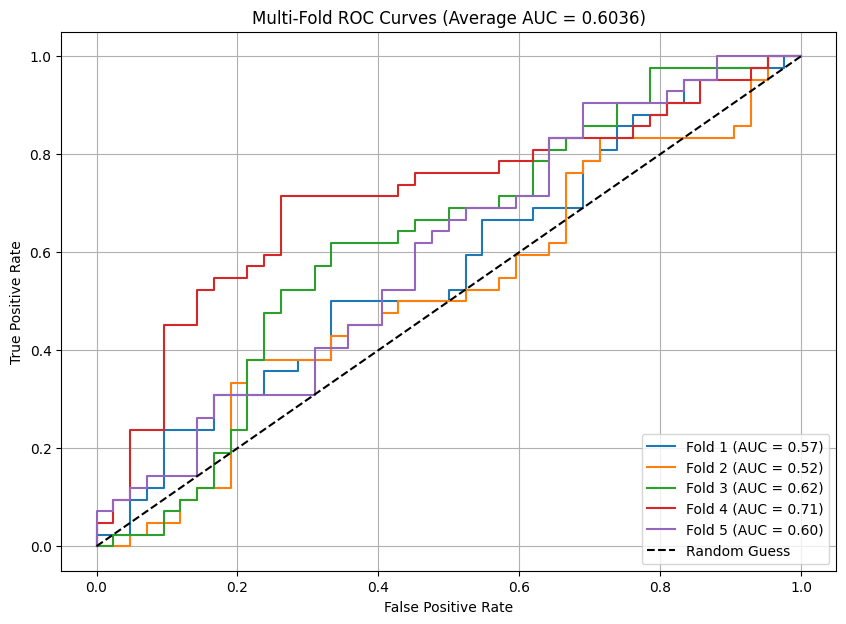

In [10]:
plt.figure(figsize=(10, 7))

for i, (targets, preds, fold_auc) in enumerate(fold_histories):
    fpr, tpr, _ = roc_curve(targets, preds)
    plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {fold_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Multi-Fold ROC Curves (Average AUC = {avg_auc:.4f})')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()